У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import plotly.express as px
import pandas as pd

In [4]:
df = pd.read_csv('drive/MyDrive/Machine Learning Course/datasources/demand-forecasting-kernels-only/train.csv')

In [5]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



Спочатку візуалізуємо тренд для одного айтема одного магазину. Бачимо сезонність змін (річну):

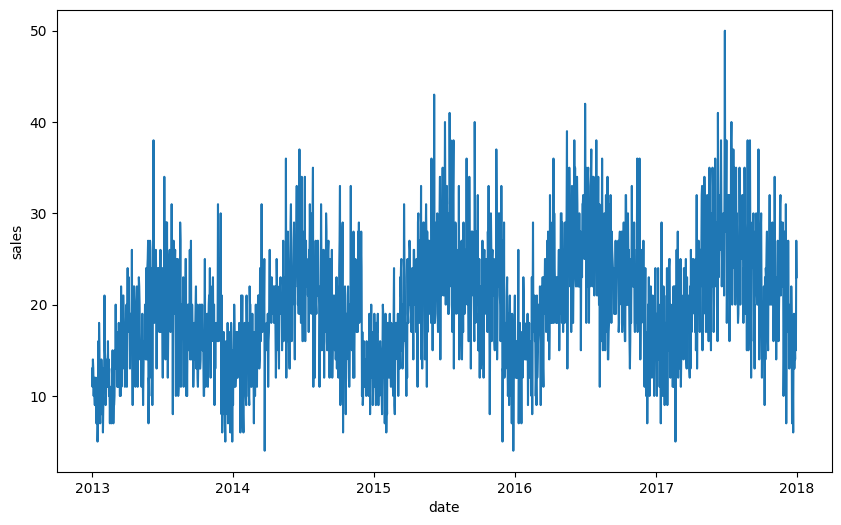

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.lineplot(
    df[(df['item'] == 1) & (df['store'] == 1)],
    x='date',
    y='sales'
)
plt.show()

In [8]:
df.index.unique().sort_values()

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=1826, freq=None)

Ми маємо дані на кожен день, але для більш зрозумілої візуалізації я пропоную згрупувати дані і дивитись тренд помісячно.

In [9]:
df_temp = df.groupby([df.index.to_period('M'), 'store', 'item'])['sales'].sum().reset_index()
df_temp['date'] = df_temp['date'].dt.to_timestamp()
df_temp.set_index('date', inplace=True)
df_temp.head()

,store,item,sales
date,,,
2013-01-01,1,1,328
2013-01-01,1,2,911
2013-01-01,1,3,547
2013-01-01,1,4,346
2013-01-01,1,5,276


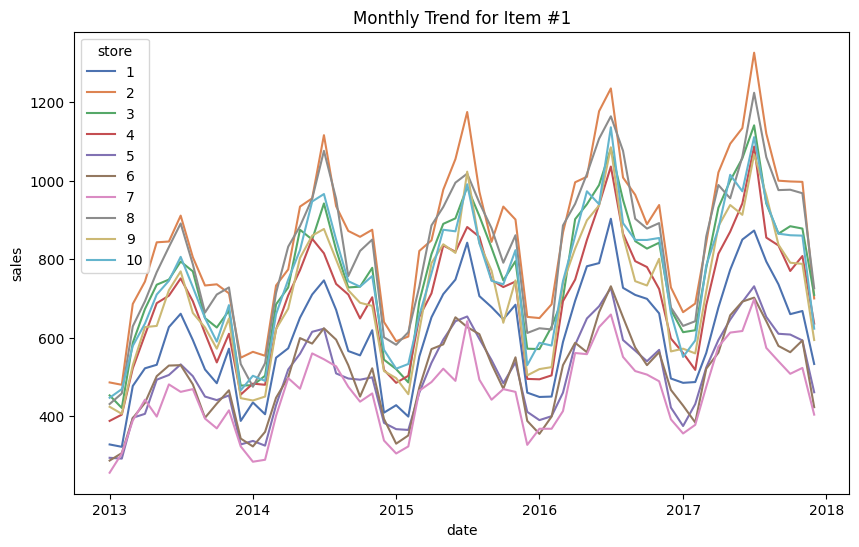

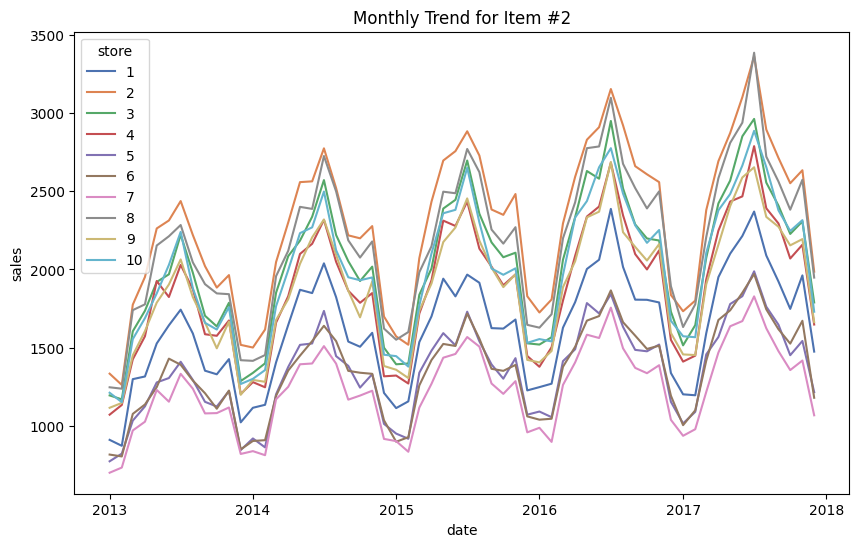

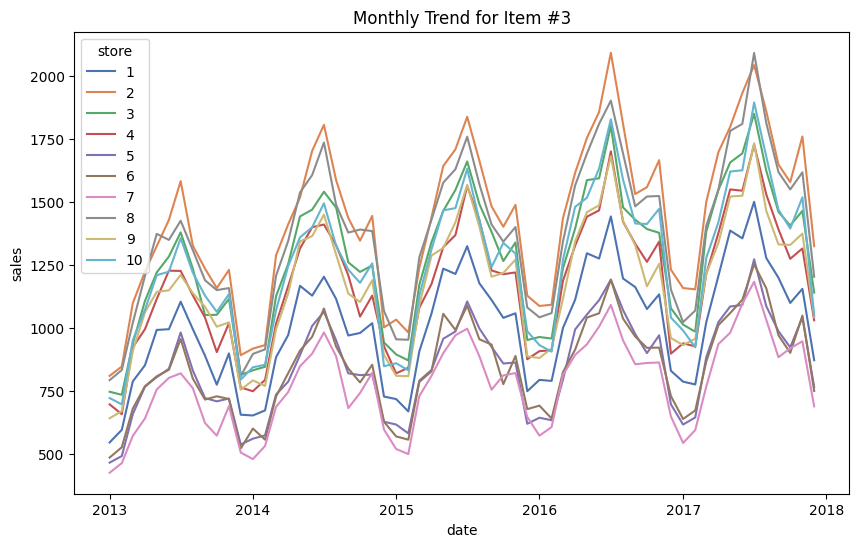

In [10]:
for i in range(1, 4):
  plt.figure(figsize=(10, 6))
  sns.lineplot(
      data=df_temp[(df_temp['item'] == i)],
      x='date',
      y='sales',
      hue='store',
      palette='deep'
  )
  plt.title(f'Monthly Trend for Item #{i}')
plt.show()

Я вивела тренд для перших трьох айтемів в усіх магазинах. Що можна сказати: всюди тренд зростаючий (а отже, продажі ростуть), для усіх трьох айтемів видно схожу тенденцію по продажах (найбільше – в 2 магазині, найменше – у 7)

In [11]:
del df_temp

Далі я хочу побудувати інтервал (мінімальне - середнє - максимальне значення) для продажу айтемів.

In [12]:
df_temp = df.groupby(['date', 'item'])['sales'].agg(['max', 'min', 'mean']).reset_index().set_index('date')
df_temp.head()

,item,max,min,mean
date,,,,
2013-01-01,1,20,7,13.3
2013-01-01,2,43,21,32.7
2013-01-01,3,26,9,17.2
2013-01-01,4,21,4,10.2
2013-01-01,5,13,4,8.3


In [13]:
for i in ['max', 'min', 'mean']:
  df_temp[f'{i}_smooth'] = df_temp.groupby('item')[i].transform(lambda x: x.rolling(window=7, center=True).mean())

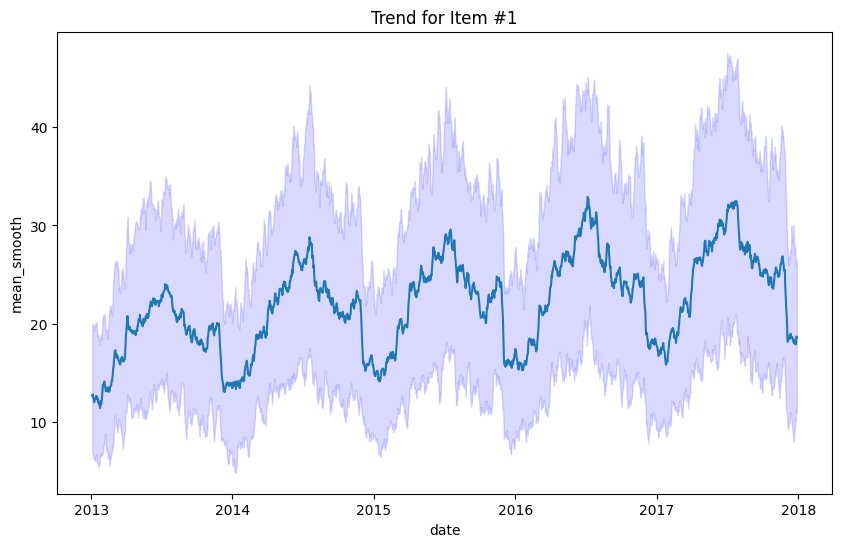

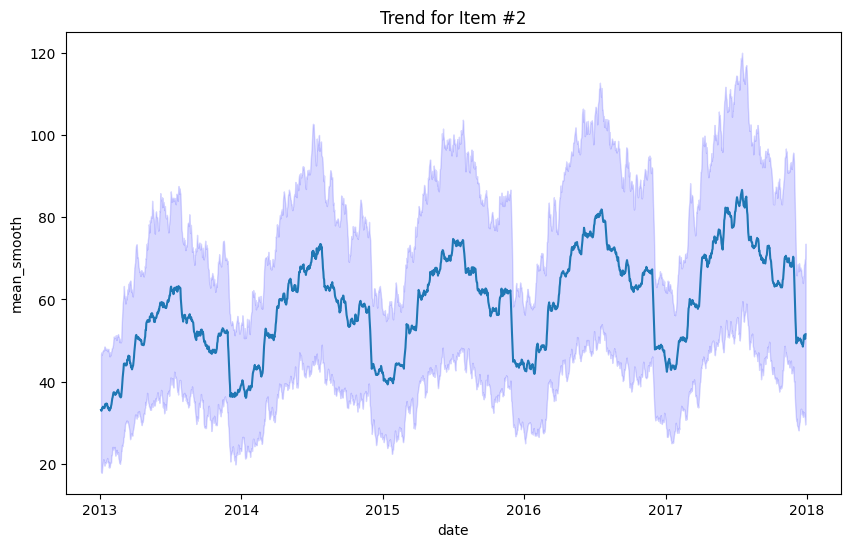

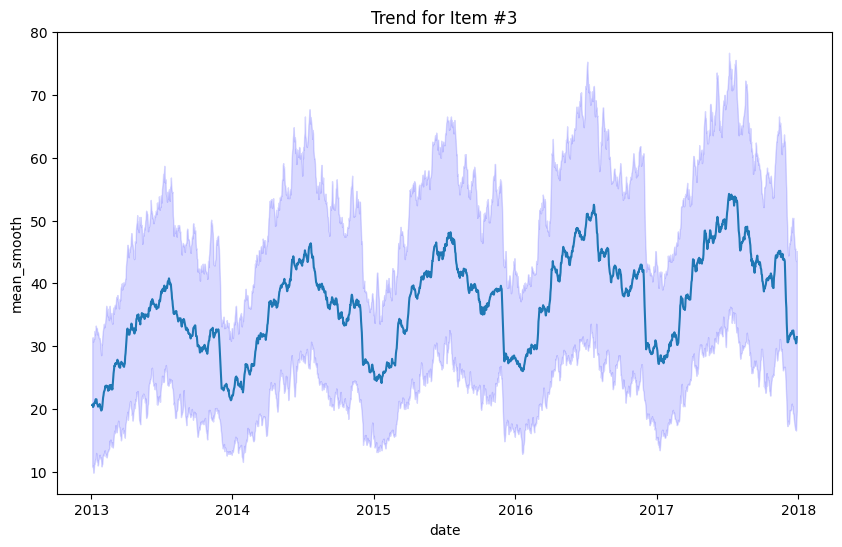

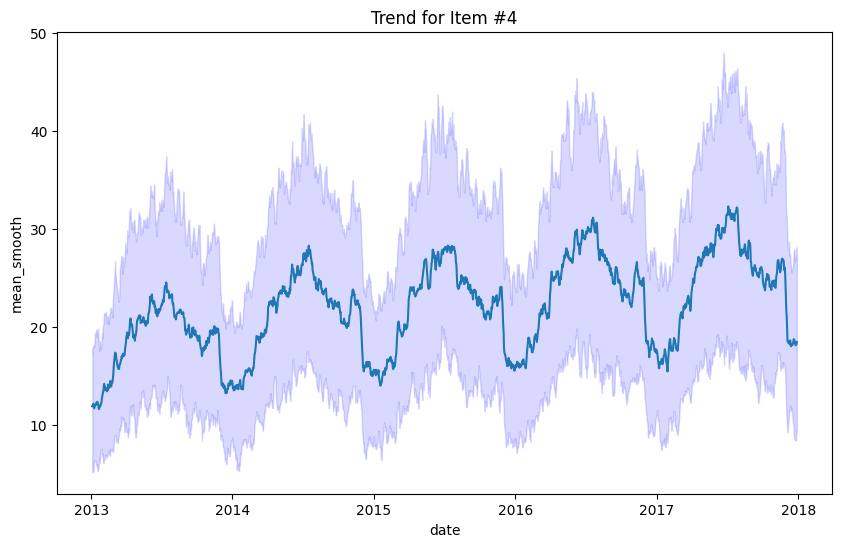

In [14]:
for i in range(1, 5):
  mask = (df_temp['item'] == i)
  plt.figure(figsize=(10, 6))
  sns.lineplot(
      data=df_temp[mask],
      x='date',
      y='mean_smooth'
  )
  plt.fill_between(
      x=df_temp[mask].index,
      y1=df_temp[mask]['min_smooth'],
      y2=df_temp[mask]['max_smooth'],
      color='b',
      alpha=0.15
  )
  plt.title(f'Trend for Item #{i}')
plt.show()

Загалом можу сказати, що тренд схожий для усіх чотирьох айтемів (хоч середнє, а відповідно, і весь інтервал, відрізняються).

In [15]:
del df_temp

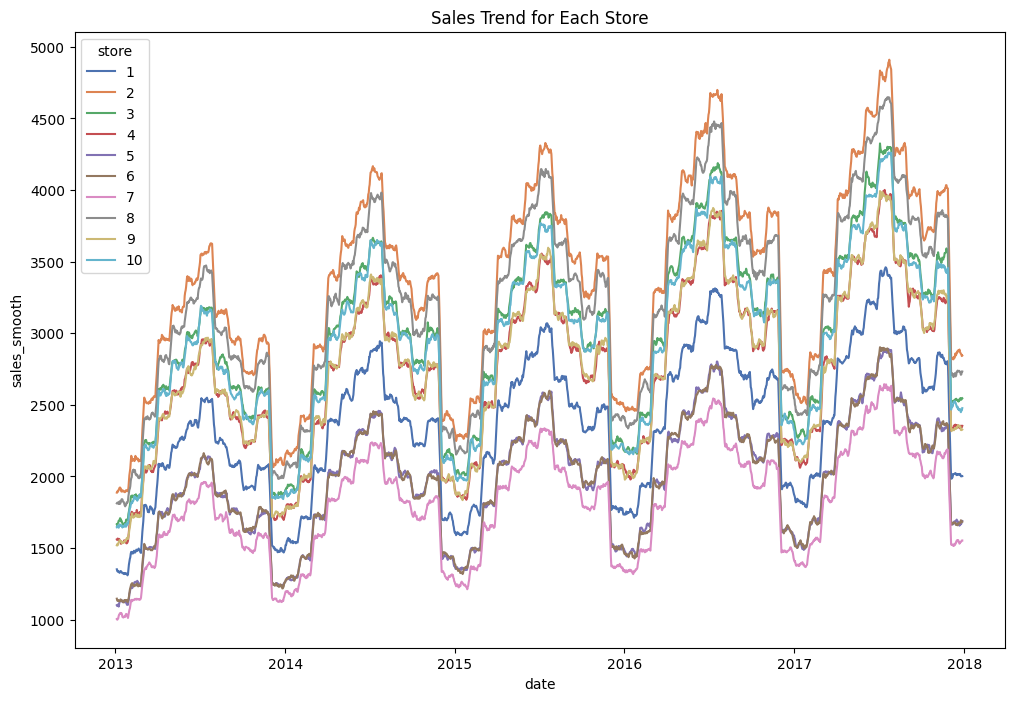

In [16]:
df_temp = df.groupby(['date', 'store'])['sales'].sum().reset_index()
df_temp = df_temp.sort_values(['store', 'date']).set_index('date')
df_temp['sales_smooth'] = df_temp.groupby('store')['sales'].transform(lambda x: x.rolling(window=7, center=True).mean())

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=df_temp.reset_index(),
    x='date',
    y='sales_smooth',
    hue='store',
    palette='deep'
)
plt.title('Sales Trend for Each Store')
plt.show()

Останнє, що вивела: тренд по продажах усіх айтемів у кожному конкретному магазині. Для зручності візуалізації ковзним середнім згладила графік. Що можемо сказати: тренд росту у всіх магазинів ідентичний + що на початку, що на кінці періоду, що розглядається, бачимо ідентичну картинку по кількості продажів (другий магазин все ще лідирує, а сьомий пасе задніх).

In [17]:
del df_temp

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [18]:
df_row = df[(df['item'] == 1) & (df['store'] == 1)]['sales']
df_row.head()

,sales
date,
2013-01-01,13
2013-01-02,11
2013-01-03,14
2013-01-04,13
2013-01-05,10


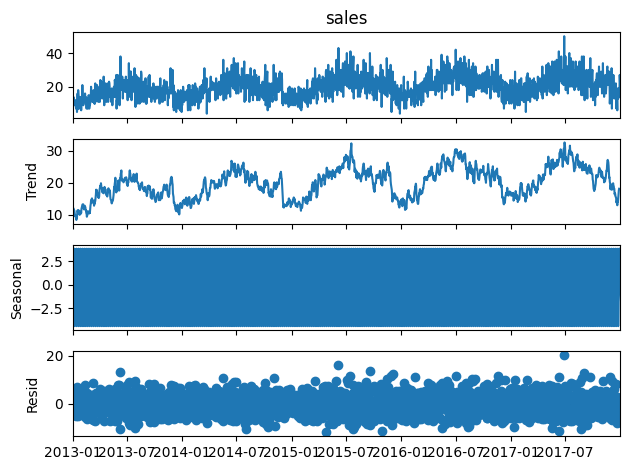

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp_add = seasonal_decompose(
    df_row,
    model='additive'
)
decomp_add.plot()
plt.show()

З отриманих результатів дуже важко робити висновки, бо, наприклад, графік сезонності взагалі не інформативний. Також тренд сам по собі уловлює сезонність. На мою думку, забагато даних: або агрегування результатів помісячно могло допомогти краще зрозуміти дані, або взяти менший період.

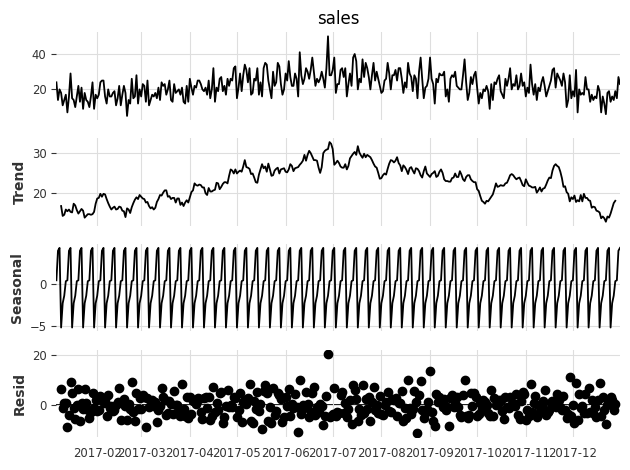

In [89]:
decomp_add = seasonal_decompose(
    df[(df['item'] == 1) & (df['store'] == 1)][-360:]['sales'],
    model='additive'
)
decomp_add.plot()
plt.show()

Якщо взяти дані за останній рік, то картинка стає зрозумілішою і чітко видно тижневу сезонність.

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [20]:
! pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [21]:
from darts import TimeSeries


df_row = df_row.reset_index()

series = TimeSeries.from_dataframe(
    df_row,
    time_col='date',
    value_cols='sales'
)

In [22]:
series

<TimeSeries (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

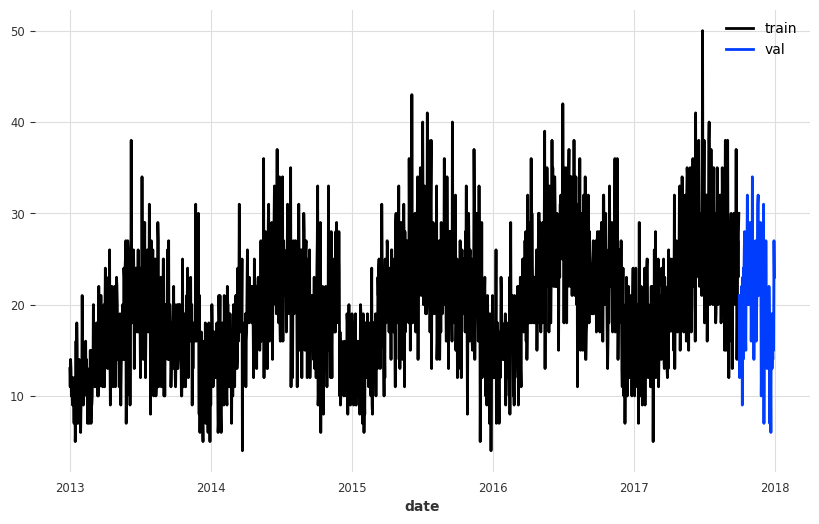

In [23]:
train, val = series.split_before(pd.Timestamp('2017-10-01'))

plt.figure(figsize=(10, 6))
train.plot(label='train')
val.plot(label='val')
plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

<Figure size 1000x800 with 0 Axes>

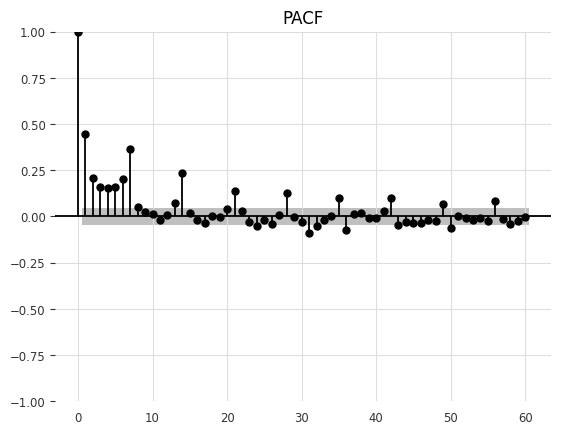

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10, 8))
plot_pacf(series.values(), lags=60)
plt.title('PACF')
plt.show();

Для прогнозування є важливими наступні лаги: 1-7, 13, 14, 21, 28, 31, 35, 42, 49, 50, 55. Отже, точно є кореляція із продажами протягом попереднього тижня (1-6) + кореляція з тим самим днем тижня в попередні тижні (7, 14, 21, 28, 35, 42, 49)

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [25]:
from darts.utils.statistics import check_seasonality

for m in range(2, 30):
  is_seasonality, period = check_seasonality(train, m=m, max_lag=30)
  if is_seasonality:
    print('seasonality of order {}.'.format(period))

seasonality of order 7.
seasonality of order 14.
seasonality of order 21.
seasonality of order 28.


Як і було видно з графіків, сезонність є, вона тижнева.

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

In [33]:
from darts.models import NaiveSeasonal, NaiveDrift

seasonal_model = NaiveSeasonal(K=7).fit(train)
drift_model = NaiveDrift().fit(train)

seasonal_predict = seasonal_model.predict(len(val))
drift_predict = drift_model.predict(len(val))

forecast = seasonal_predict + drift_predict - train.last_value()

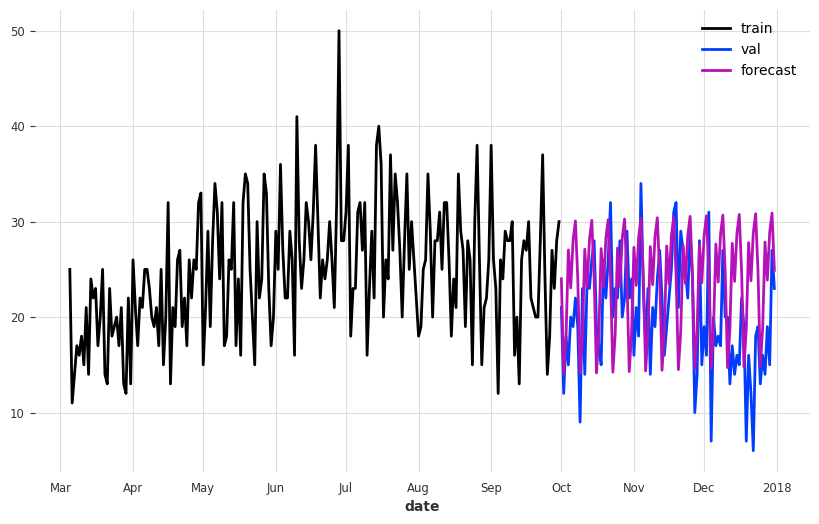

In [34]:
plt.figure(figsize=(10, 6))
train[-210:].plot(label='train')
val.plot(label='val')
# seasonal_predict.plot(label='seasonal')
# drift_predict.plot(label='drift')
forecast.plot(label='forecast')
plt.legend()
plt.show()

Модель доволі добре вловлює сезонність, але при цьому їй не вдалося передбачити тренд (у валідаційних даних ряд трохи на спад починає іти).

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [36]:
from darts.metrics import mape

mape(val, forecast)

np.float64(39.90628951234137)

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [40]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler

def enrich_with_date_features(df):
  df['dayofweek'] = df['date'].dt.dayofweek
  #df['quarter'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  #df['dayofyear'] = df['date'].dt.dayofyear
  #df['dayofmonth'] = df['date'].dt.day
  return df

In [103]:
train_transformed = enrich_with_date_features(train.to_dataframe().reset_index())
val_transformed = enrich_with_date_features(val.to_dataframe().reset_index())

scaler = Scaler()
train_transformed = scaler.fit_transform(train)

model = XGBModel(
    lags=7,
    output_chunk_length=1,
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

model.fit(train_transformed)
forecast = scaler.inverse_transform(model.predict(len(val)))

mape(val, forecast)

np.float64(26.703689151685314)

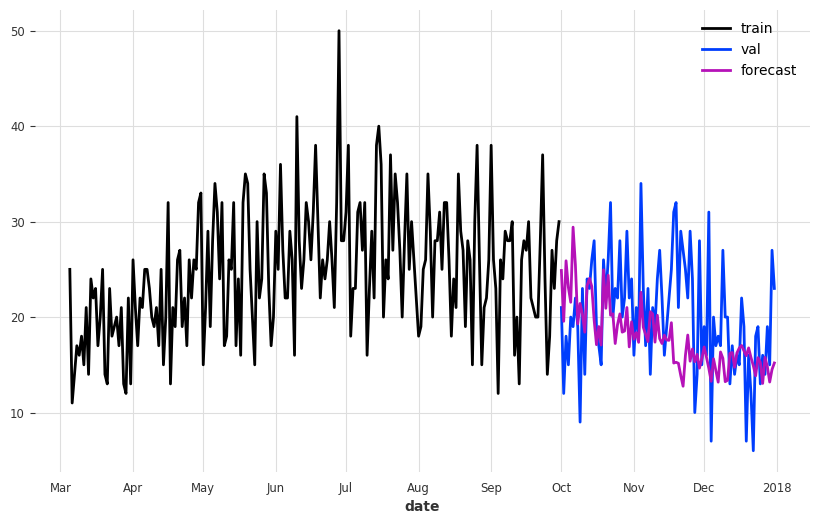

In [104]:
plt.figure(figsize=(10, 6))
train[-210:].plot(label='train')
val.plot(label='val')
forecast.plot(label='forecast')
plt.legend()
plt.show()

На мою думку, модель спрацювала погано: МАРЕ 27%, але тренд і сезонність не дуже добре піймала.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

In [68]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
forecast = model.predict(len(val))

mape(val, forecast)

np.float64(39.00856138800186)

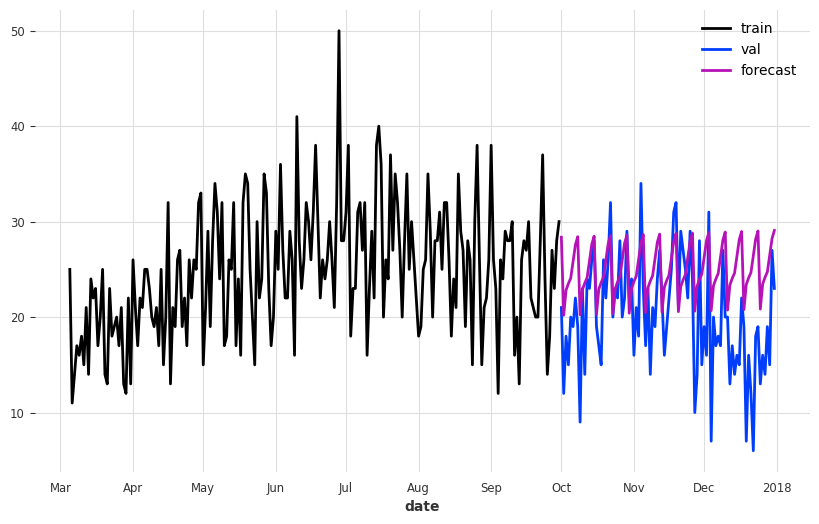

In [69]:
plt.figure(figsize=(10, 6))
train[-210:].plot(label='train')
val.plot(label='val')
forecast.plot(label='forecast')
plt.legend()
plt.show()

Якість цієї моделі ще гірша (39%): є сезонність, але абсолютно не збігається тренд.

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

In [80]:
from darts.models import ARIMA

model = ARIMA(p=7, d=1, q=1)
model.fit(train)
forecast = model.predict(len(val))

mape(val, forecast)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


np.float64(39.52818300569095)

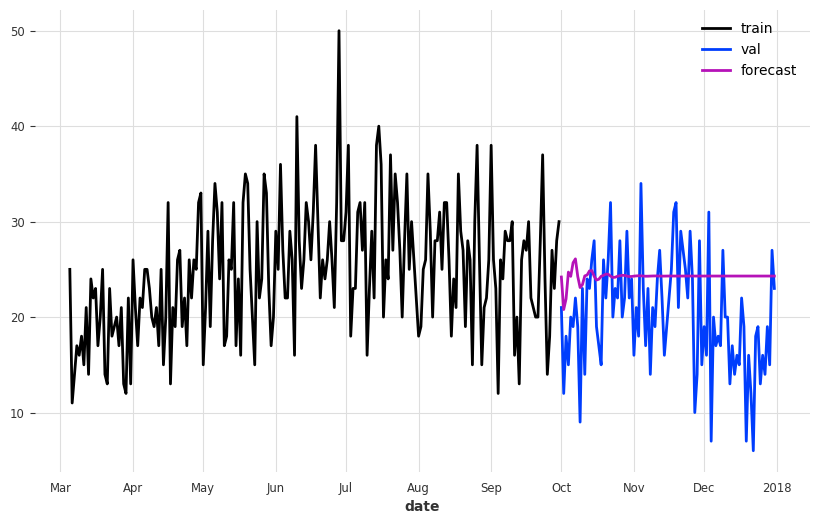

In [81]:
plt.figure(figsize=(10, 6))
train[-210:].plot(label='train')
val.plot(label='val')
forecast.plot(label='forecast')
plt.legend()
plt.show()

Модель вийшла поганою (підбір параметрів кращих результатів не дав): МАРЕ 39%, модель перші значення намагається підібрати, а пізніші значення віддає константами.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

In [96]:
from darts.models import AutoARIMA

model = AutoARIMA(
    start_p=1, max_p=30, start_q=1
)
model.fit(train)
forecast = model.predict(len(val))

mape(val, forecast)

np.float64(40.294072271660795)

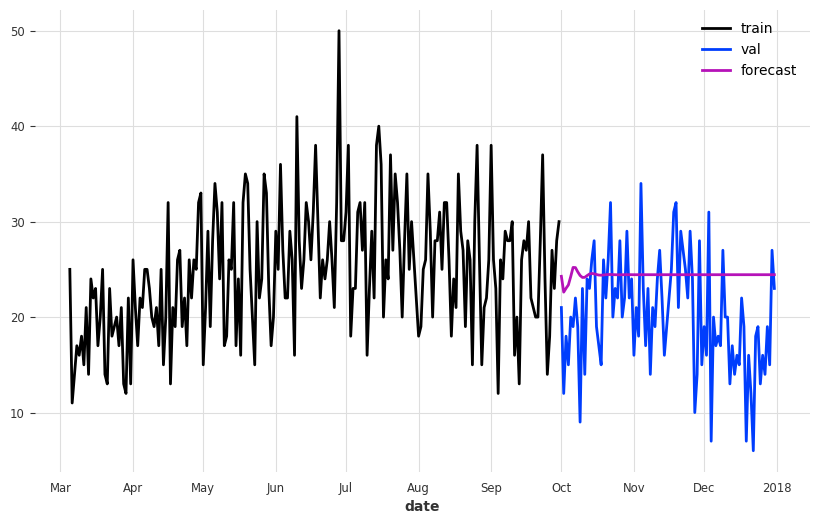

In [97]:
plt.figure(figsize=(10, 6))
train[-210:].plot(label='train')
val.plot(label='val')
forecast.plot(label='forecast')
plt.legend()
plt.show()

На жаль, ця модель вийшла ще гіршою, якість моделі полішити не вдалося.

14. Натренуйте модель Prophet та зробіть висновок про її якість.

In [98]:
from darts.models import Prophet

model = Prophet()
model.fit(train)
forecast = model.predict(len(val))

mape(val, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv8jmv88n/bk7q808j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv8jmv88n/nw1h7olh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26065', 'data', 'file=/tmp/tmpv8jmv88n/bk7q808j.json', 'init=/tmp/tmpv8jmv88n/nw1h7olh.json', 'output', 'file=/tmp/tmpv8jmv88n/prophet_model49ebdx7_/prophet_model-20251001142315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:23:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:23:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


np.float64(23.80480380321674)

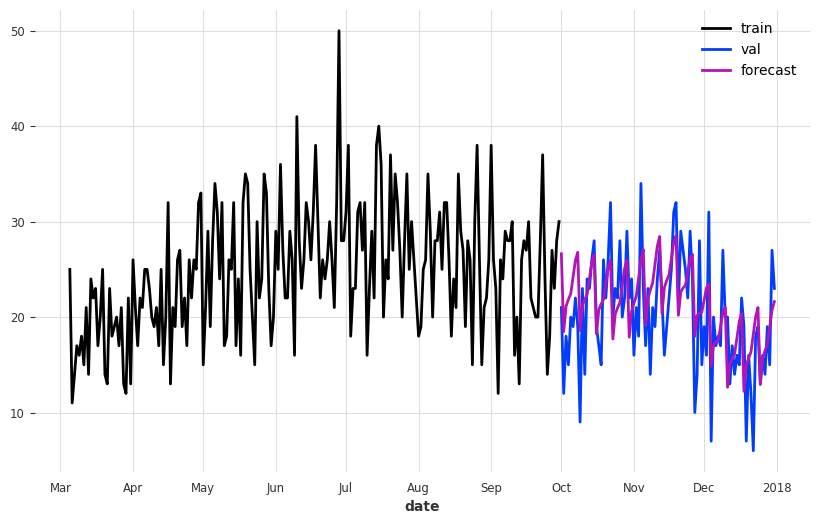

In [99]:
plt.figure(figsize=(10, 6))
train[-210:].plot(label='train')
val.plot(label='val')
forecast.plot(label='forecast')
plt.legend()
plt.show()

Ця модель вийшла найкрощою з усього, що будувалось вище (найголовніше: вловлюється тренд), але якість все ще не дуже задовільна (наприклад, не найкращим чином враховується сезонність).

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

In [106]:
from darts.models import RNNModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries


year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, periods=2000),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp('2017-10-01'))


model = RNNModel(
    model="LSTM",
    input_chunk_length=14,
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    force_reset=True,
)
model.fit(
    train_transformed,
    future_covariates=covariates,
    val_future_covariates=covariates,
    verbose=True)


forecast = scaler.inverse_transform(model.predict(len(val)))
mape(val, forecast)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.9 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

np.float64(27.348110392661052)

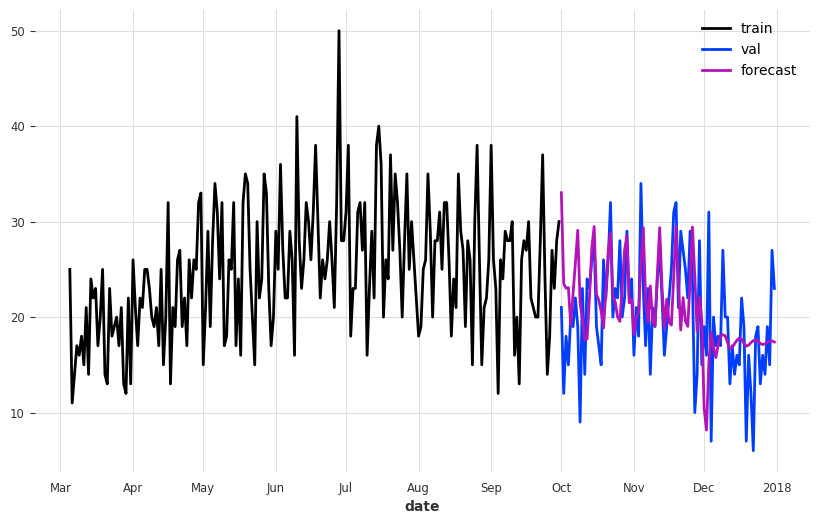

In [107]:
plt.figure(figsize=(10, 6))
train[-210:].plot(label='train')
val.plot(label='val')
forecast.plot(label='forecast')
plt.legend()
plt.show()

Модель вийшла не найкращою: МАРЕ 27%, а в кінці валідаційних даних модель перестала відловлювати будь-які закономірності.

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

In [109]:
model = Prophet()
model.fit(train)
forecast = model.predict(len(val))

mape(val, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv8jmv88n/1xbmt444.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv8jmv88n/3h7l893v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88494', 'data', 'file=/tmp/tmpv8jmv88n/1xbmt444.json', 'init=/tmp/tmpv8jmv88n/3h7l893v.json', 'output', 'file=/tmp/tmpv8jmv88n/prophet_modelwwrhjbou/prophet_model-20251001144151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


np.float64(23.80480380321674)

Streaming output truncated to the last 5000 lines.
14:54:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:54:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
historical forecasts:  68%|██████▊   | 978/1432 [03:11<01:22,  5.50it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv8jmv88n/mxqnkagx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv8jmv88n/z9rh7wpy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76898', 'data', 'file=/tmp/tmpv8jmv88n/mxqnkagx.json', 'init=/tmp/tmpv8jmv88n/z9rh7wpy.json', 'output', 'file=/tmp/tmpv8jmv88n/prophet_modelwtgwp0oq/prop

MAPE = 29.98%


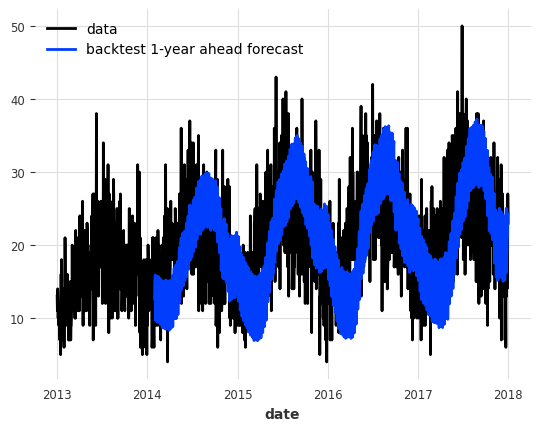

In [113]:
hfc_params = {
    'series': series,
    'forecast_horizon': 30,
    'verbose': True,
    'train_length': 365
}

historical_fcast = model.historical_forecasts(
    last_points_only=True,
    **hfc_params
)

series.plot(label='data')
historical_fcast.plot(label='backtest 1-year ahead forecast')
print(f'MAPE = {mape(series, historical_fcast):.2f}%')

historical forecasts:   0%|          | 0/48 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv8jmv88n/e3i07th8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv8jmv88n/yhmel95w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29786', 'data', 'file=/tmp/tmpv8jmv88n/e3i07th8.json', 'init=/tmp/tmpv8jmv88n/yhmel95w.json', 'output', 'file=/tmp/tmpv8jmv88n/prophet_modelsun1i2es/prophet_model-20251001145702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:57:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:57:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain 

MAPE = 26.13%


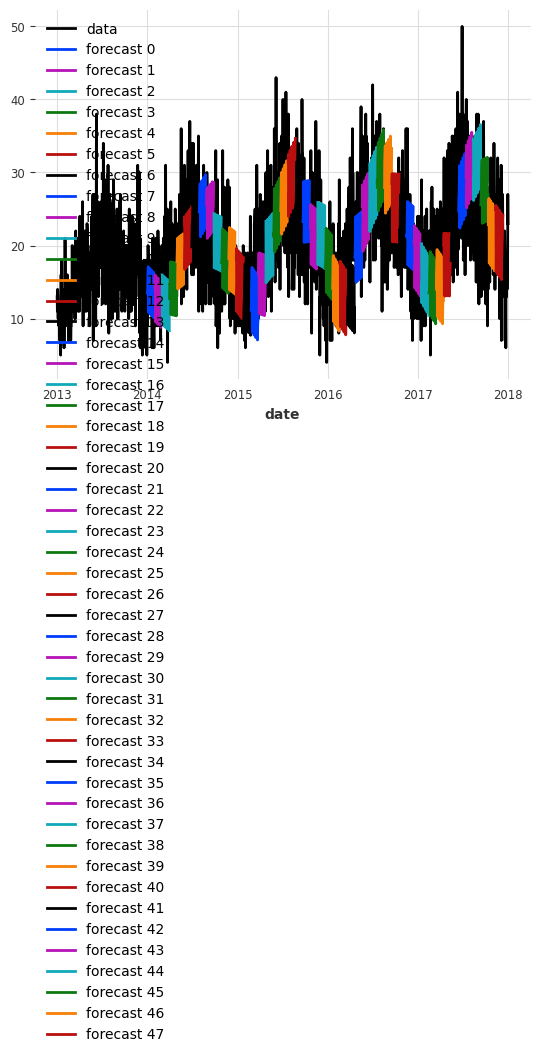

In [114]:
historical_fcast_all = model.historical_forecasts(last_points_only=False, stride=30, **hfc_params)

series.plot(label="data")
for idx, hfc in enumerate(historical_fcast_all):
    hfc.plot(label=f"forecast {idx}")

from darts import concatenate
historical_fcast_all = concatenate(historical_fcast_all, axis=0)
print(f"MAPE = {mape(series, historical_fcast_all):.2f}%")

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Я б використовувала ту модель, яка на одному айтемі показала найкращий результат.
Я б спробувала побудувати моделі для i-го айтема в N магазинах – якби тренд був ідентичний, то залишила одну модель для i-го айтема для всіх магазинів. Аналогічно б пробувала будувати моделі для n кількості айтемів в певному магазині – якщо є кореляція (наприклад, тренд покупок 2-го айтема повторює тренд покупок 1-го), то я б вже рухалась аналітично і, побудувавши одну модель, рахувала коефіцієнти для кожного айтема і потім би додавала результати. Тобто метою було б використання найменшою кількості потужностей (меншої кількості моделей, щоб це можна було скейлити на більшу кількість айтемів і магазинів) із найбільшим рівнем точності.